# Bayesian Analysis
- detecting AI generated text
- final project for GT Analytics Bayesian Stats course
- 11/28/2023
- inspired by the Kaggle Competition

https://www.kaggle.com/datasets/thedrcat/daigt-external-train-dataset. This dataset was found via the Kaggle competition for determining AI generated text: LLM - Detect AI Generated Text | Kaggle

In [1]:
%cd /content/drive/MyDrive/Classes/OMS_baysian/bayesian_project

/content/drive/MyDrive/Classes/OMS_baysian/bayesian_project


In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import make_scorer, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
# import language_tool_python
from concurrent.futures import ProcessPoolExecutor

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Read the CSV file
df = pd.read_csv('train_essays.csv')
split_index = int(0.8 * len(df))

# Split the DataFrame into training and test sets
train_df = df[:split_index]
test_df = df[split_index:]



In [4]:
# Read the CSV file into a DataFrame (this will be the dataset I ultimately use as it has much more ai generated text)
df_cat = pd.read_csv('train_v2_drcat_02.csv', error_bad_lines=False)

split_index = int(0.8 * len(df_cat))

# Split the DataFrame into training and test sets
train_df_cat = df[:split_index]
test_df_cat = df[split_index:]



<ipython-input-4-4ac8a169ad5a>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_cat = pd.read_csv('train_v2_drcat_02.csv', error_bad_lines=False)


In [5]:
print(df_cat.head())
df_cat['label'].value_counts()

                                                text  label  \
0  Phones\n\nModern humans today are always on th...      0   
1  This essay will explain if drivers should or s...      0   
2  Driving while the use of cellular devices\n\nT...      0   
3  Phones & Driving\n\nDrivers should not be able...      0   
4  Cell Phone Operation While Driving\n\nThe abil...      0   

          prompt_name           source  RDizzl3_seven  
0  Phones and driving  persuade_corpus          False  
1  Phones and driving  persuade_corpus          False  
2  Phones and driving  persuade_corpus          False  
3  Phones and driving  persuade_corpus          False  
4  Phones and driving  persuade_corpus          False  


0    27371
1    17497
Name: label, dtype: int64

In [6]:
# combine data

stacked_column = pd.concat([df['generated'], df_cat['label']], axis=0)
# Reset the index of the resulting Series (optional)
stacked_column = stacked_column.reset_index(drop=True)


# Stack the "generated" column on top of the "label" column
stacked_column2 = pd.concat([df['text'], df_cat['text']], axis=0)

stacked_column2 = stacked_column2.reset_index(drop=True)
new_df = pd.DataFrame({'generated': stacked_column, 'text': stacked_column2})

# Display the first few rows of 'new_df'
new_df.head()



,generated,text
0,0,Cars. Cars have been around since they became ...
1,0,Transportation is a large necessity in most co...
2,0,"""America's love affair with it's vehicles seem..."
3,0,How often do you ride in a car? Do you drive a...
4,0,Cars are a wonderful thing. They are perhaps o...


In [7]:

# Shuffle the DataFrame
shuffled_df = new_df.sample(frac=1, random_state=42)  # Set a random seed for reproducibility )

selected_df = shuffled_df.head(5000)
# Display the first few rows of 'selected_df'
selected_df.head()


,generated,text
5525,0,Does working on a school project during your s...
20487,0,"Dear Senator,\n\nI believe that the United Sta..."
26827,0,Sometimes when you are in a tough spot you see...
4246,0,Did you know that passenger cars are responsib...
28638,1,I believe that students should have the right ...


In [8]:
df = selected_df

In [9]:
# vectorize
vectorizer = TfidfVectorizer(ngram_range=(1, 7),sublinear_tf=True)
vectorizer = vectorizer.fit(df['text'])
X = vectorizer.transform(df['text'])

In [10]:

# Calculate the index where the split should occur
split_index = int(0.8 * len(df))

# Split the DataFrame into training and test sets
train_df = selected_df[:split_index]
test_df = selected_df[split_index:]

In [11]:
x_train = X[train_df.shape[0]:]
y_train = train_df['generated']
x_test = X[:test_df.shape[0]]
y_test = test_df['generated']
# X_tfidf = x_train.toarray()
X_train_dense = x_train.toarray()  # Convert to dense matrix
X_test_dense = x_test.toarray()


In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Load Data
# note I wound up doing an even 50 50 split of data train and test due to issues i had with sampling dimensions

# Feature Extraction with TF-IDF
tfidf = TfidfVectorizer(max_features=500)  # Adjust max_features as needed
X = tfidf.fit_transform(train_df['text'].append(test_df['text']))
y = train_df['generated'].append(test_df['generated'])

# Splitting the data back into train and test sets
x_train = X[:train_df.shape[0]]
y_train = train_df['generated']
x_test = X[train_df.shape[0]:]
y_test = test_df['generated']

# Convert to Dense Matrix
X_train_dense = x_train.toarray()
X_test_dense = x_test.toarray()

# Define Bayesian Model
with pm.Model() as model:

    feature_data = pm.Data("features", X_train_dense)


    # Priors
    # alpha = pm.Normal('alpha', mu=0, sigma=10)
    # beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train_dense.shape[1])
    alpha = pm.Normal('alpha', mu=0, sigma=5)  # Example: tighter prior
    beta = pm.Normal('beta', mu=0, sigma=20, shape=X_train_dense.shape[1])  # Example: looser prior


    # Likelihood
    p = pm.math.sigmoid(alpha + pm.math.dot(X_train_dense, beta))
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_train)

    # Inference
    trace = pm.sample(1000, tune=200, return_inferencedata=True)
    # trace = pm.sample(10, tune=20, return_inferencedata=True)


<ipython-input-70-13fc55e65e55>:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = tfidf.fit_transform(train_df['text'].append(test_df['text']))
<ipython-input-70-13fc55e65e55>:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = train_df['generated'].append(test_df['generated'])
/usr/local/lib/python3.10/dist-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [ ]:
# ADDITIONAL ANALYSIS

# Extract beta coefficients
beta_coefficients = trace.posterior['beta'].mean(dim=['chain', 'draw']).values

# Mapping coefficients to words
feature_names = tfidf.get_feature_names_out()
word_importance = pd.DataFrame({'word': feature_names, 'importance': beta_coefficients})

# Top words indicating AI-generated text
top_ai_words = word_importance.sort_values('importance', ascending=False).head(10)
top_human_words = word_importance.sort_values('importance').head(10)

print("AI-Indicative Words:\n", top_ai_words)
print("\nHuman-Indicative Words:\n", top_human_words)


AI-Indicative Words:
            word  importance
96   conclusion   54.191287
335   potential   47.371476
344     provide   44.935590
219   important   43.170028
165     finally   41.000250
349          re   38.161741
58     benefits   36.670641
25          and   36.081192
401     success   35.340655
167       first   34.478551

Human-Indicative Words:
          word  importance
50    because  -67.410925
140  electors  -40.382121
352    reason  -40.046939
262      many  -39.115481
461      very  -38.774920
184     going  -37.171384
20   although  -36.388577
320   percent  -34.335229
466    voting  -33.814789
149      even  -32.442807


<ipython-input-72-a6775801be68>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(trace.posterior['beta'][:, :, feature].values.ravel(), label=f'Feature {feature}')
<ipython-input-72-a6775801be68>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(trace.posterior['beta'][:, :, feature].values.ravel

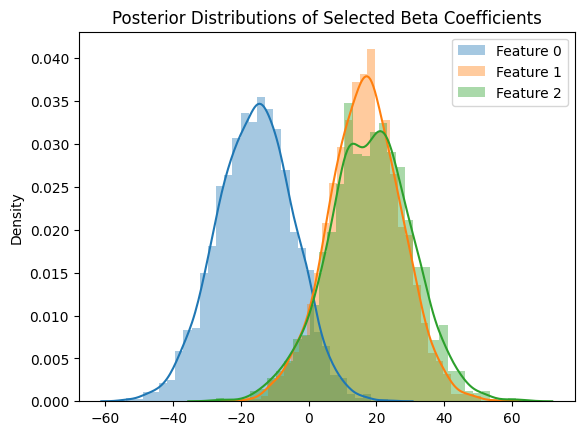

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_features = [0, 1, 2]  # indices of features of interest
for feature in selected_features:
    sns.distplot(trace.posterior['beta'][:, :, feature].values.ravel(), label=f'Feature {feature}')
plt.legend()
plt.title('Posterior Distributions of Selected Beta Coefficients')
plt.show()


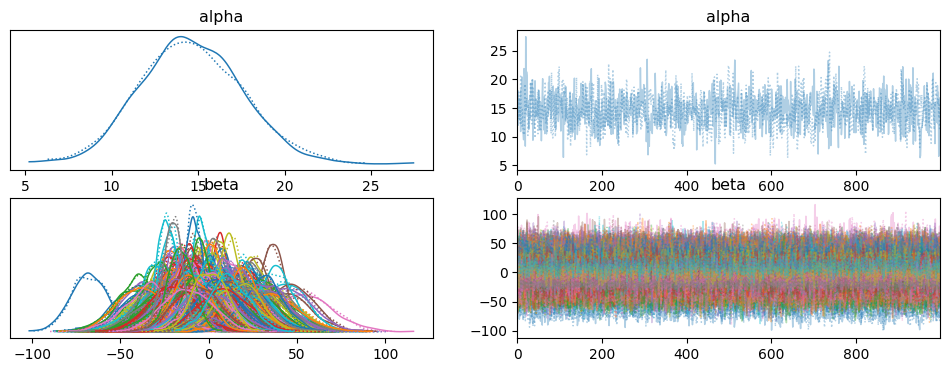

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1002) in plot_autocorr, generating only 40 plots
  warnings.warn(


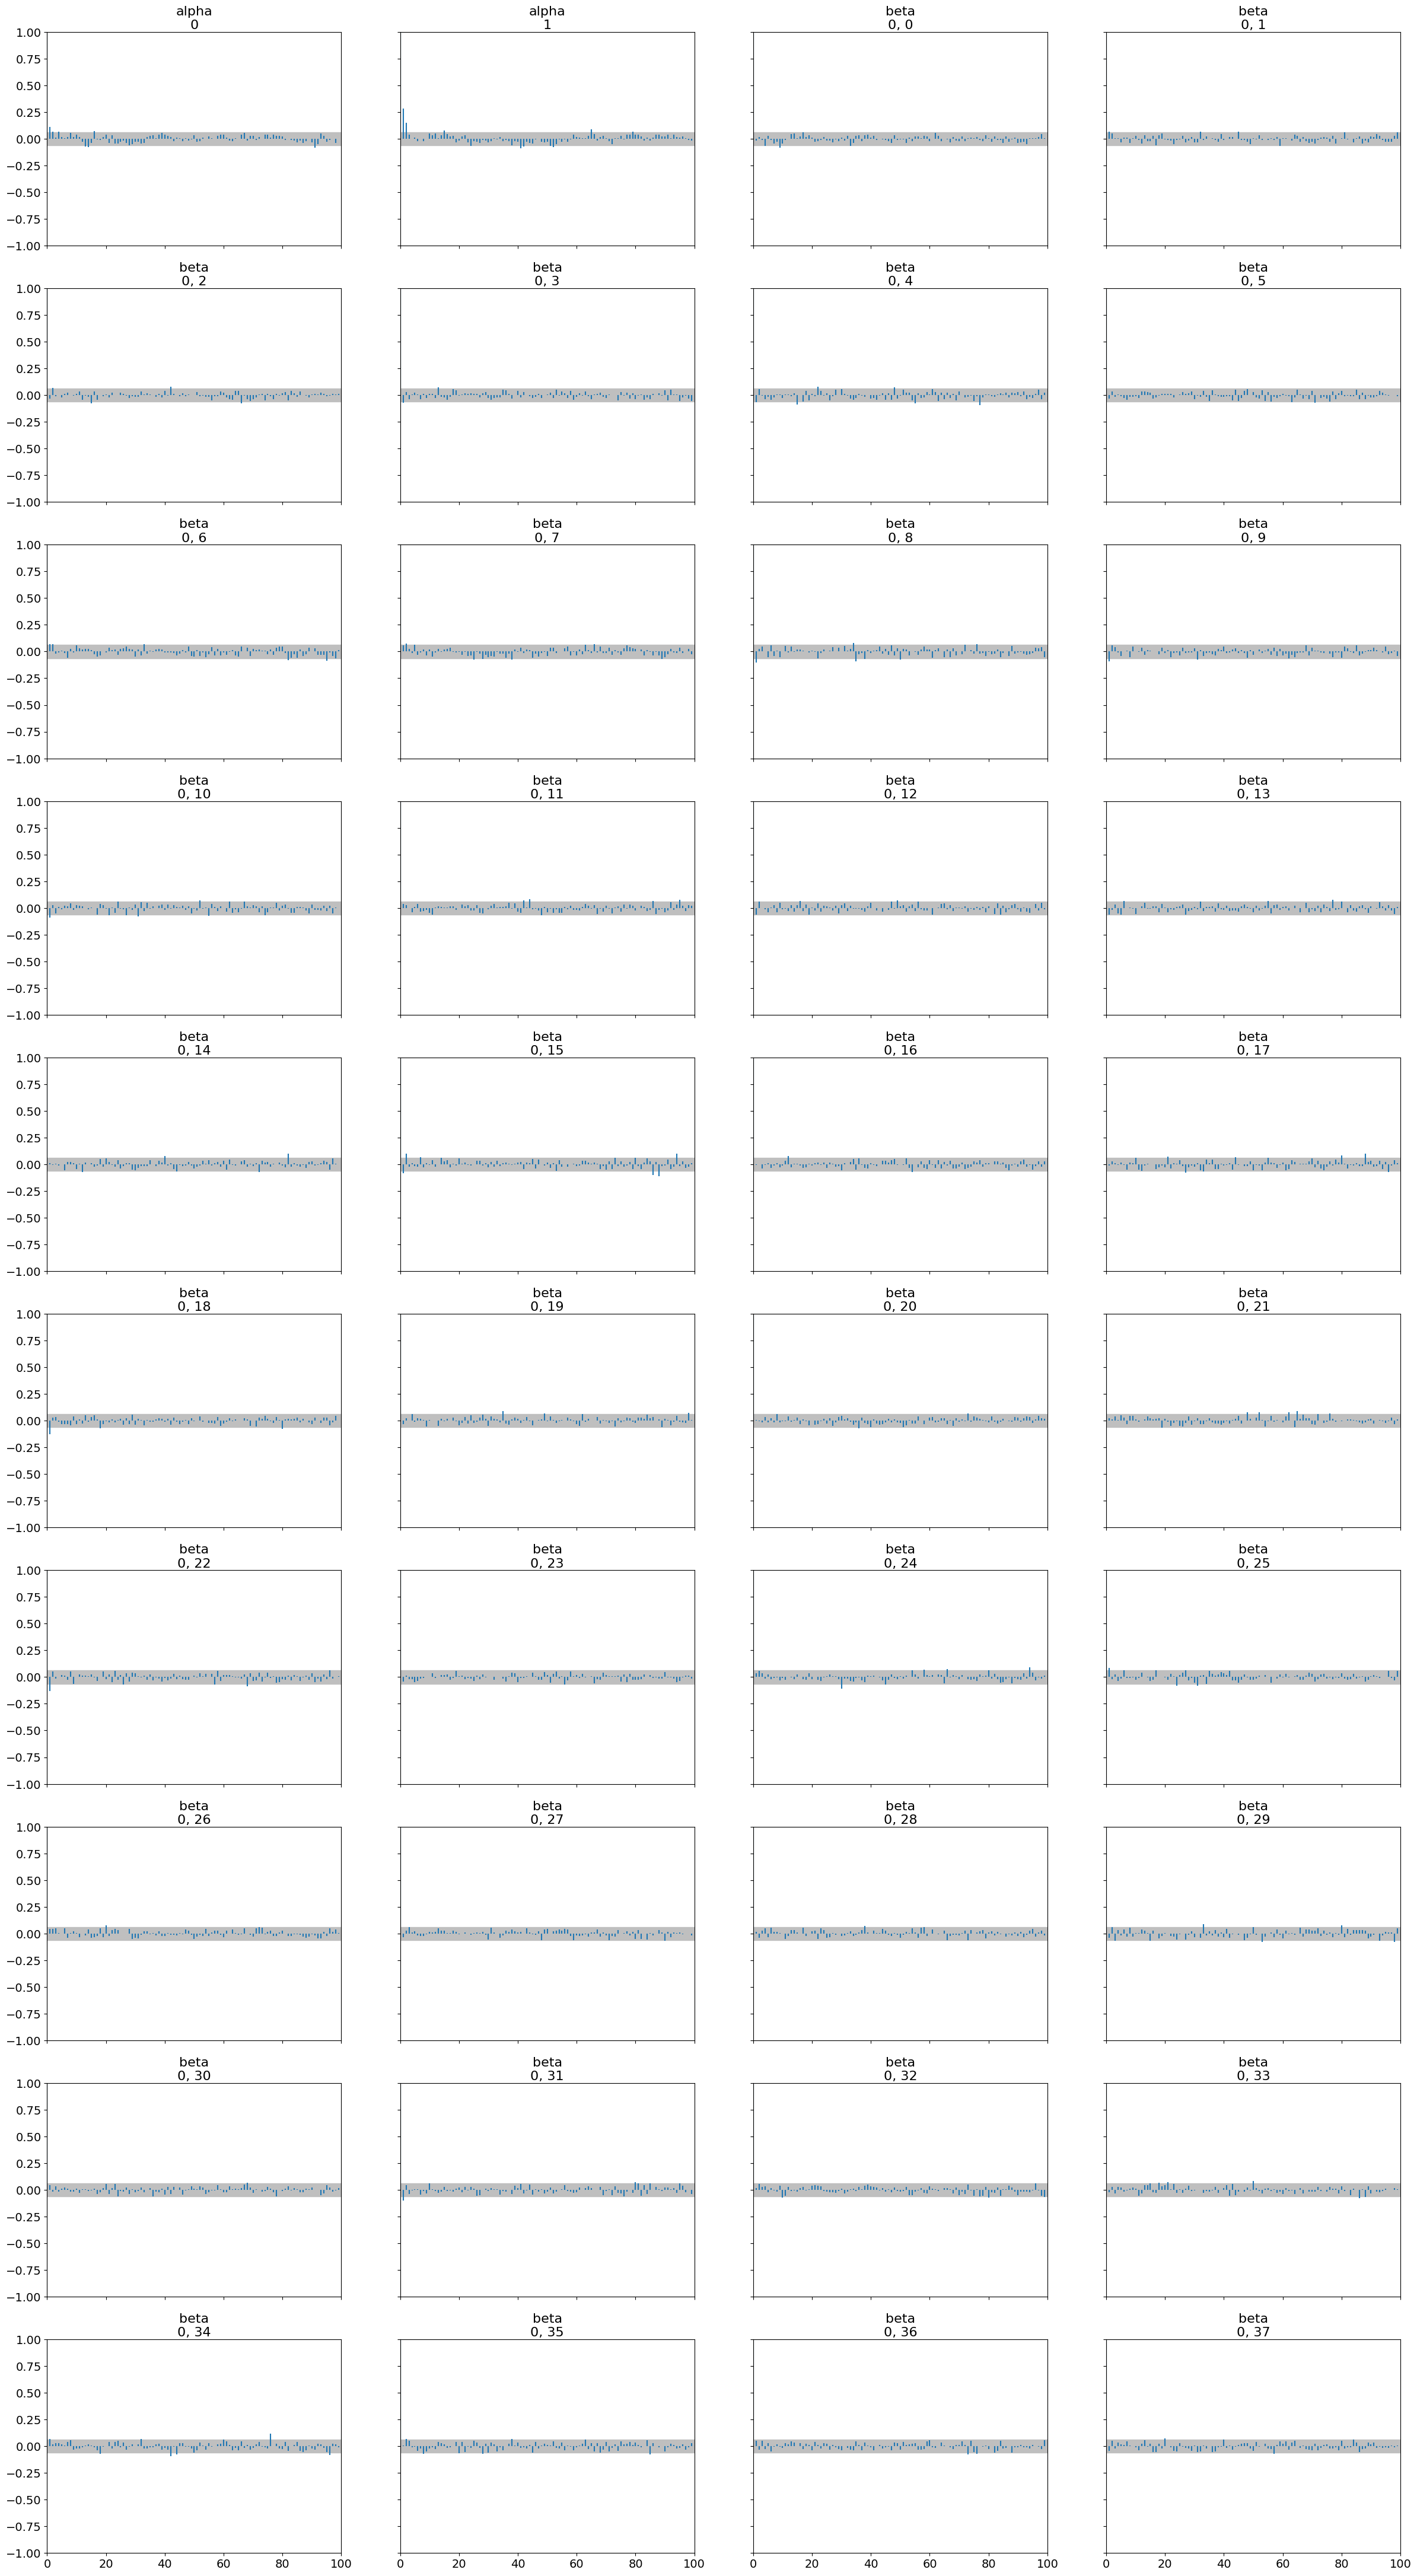

In [ ]:
import arviz as az
az.plot_trace(trace)
plt.show()

az.plot_autocorr(trace)
plt.show()


In [ ]:
def predict(X, trace):
    alpha_mean = trace.posterior['alpha'].mean().values
    beta_mean = trace.posterior['beta'].mean(dim=['chain', 'draw']).values
    p = 1 / (1 + np.exp(-(alpha_mean + np.dot(X, beta_mean))))
    return ((p > 0.5).astype(int), p)


y_pred, probs = predict(X_test_dense, trace)



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.971
Precision: 0.9598997493734336
Recall: 0.9671717171717171
F1 Score: 0.9635220125786164
Confusion Matrix:
[[588  16]
 [ 13 383]]


In [ ]:
from sklearn.metrics import roc_auc_score

def predict(X, trace):
    alpha_mean = trace.posterior['alpha'].mean().values
    beta_mean = trace.posterior['beta'].mean(dim=['chain', 'draw']).values
    p = 1 / (1 + np.exp(-(alpha_mean + np.dot(X, beta_mean))))
    return ((p > 0.5).astype(int), p)

# Predicting on Test Data
y_pred, probs = predict(X_test_dense, trace)

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, probs)
print(f"ROC-AUC Score: {roc_auc}")


ROC-AUC Score: 0.9965925814435748


# ITERATION 3

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Concatenate the dataframes
full_df = pd.concat([train_df, test_df])

# Feature Extraction with TF-IDF
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(full_df['text'])

# Labels
y = full_df['generated']

# Splitting the data into train and test sets, ensuring equal size
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Convert to Dense Matrix
X_train_dense = x_train.toarray()
X_test_dense = x_test.toarray()
# Define Bayesian Model
with pm.Model() as model:
    # Create a shared variable for feature data
    feature_data = pm.MutableData("features", X_train_dense)

    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=5)  # Example: tighter prior
    beta = pm.Normal('beta', mu=0, sigma=20, shape=X_train_dense.shape[1])  # Example: looser prior

    # Likelihood - IMPORTANT: Use 'feature_data' here instead of 'X_train_dense'
    p = pm.math.sigmoid(alpha + pm.math.dot(feature_data, beta))
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_train)

    # Inference
    trace = pm.sample(2500, tune=500, return_inferencedata=True)

# After training the model, switch to test data and generate posterior predictive checks
with model:
    pm.set_data({"features": X_test_dense})
    ppc = pm.sample_posterior_predictive(trace, var_names=['y_obs'])

In [ ]:
# Calculate the mean predicted probabilities for test data
mean_prediction_test = ppc.posterior_predictive['y_obs'].mean(axis=0)

# Convert probabilities to binary predictions
predictions_test = (mean_prediction_test > 0.5).astype(int)


In [ ]:

# Convert xarray.DataArray to NumPy array
predictions_test_array = predictions_test.values

# Calculate the mean predicted probabilities across the samples
mean_prediction_test = np.mean(predictions_test_array, axis=0)

binary_predictions_test = (mean_prediction_test > 0.5).astype(int)

In [ ]:
# Calculate metrics
accuracy_test = accuracy_score(y_test, binary_predictions_test)
accuracy_test

0.9704

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculating metrics
accuracy = accuracy_score(y_test, binary_predictions_test)
precision = precision_score(y_test, binary_predictions_test)
recall = recall_score(y_test, binary_predictions_test)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 0.9704
Precision: 0.9900771775082691
Recall: 0.9325025960539979


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


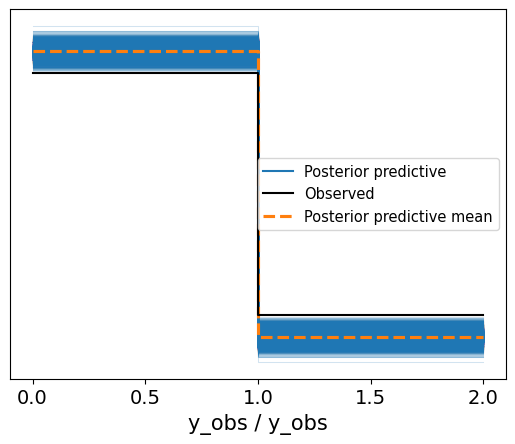

In [ ]:
import arviz as az

with model:
    ppc = pm.sample_posterior_predictive(trace)
    az.plot_ppc(ppc, kind="kde")


In [ ]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

# iteration 3

In [ ]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [14]:
# with LOG

import pandas as pd
import numpy as np
import pymc as pm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


# Feature Extraction with TF-IDF
tfidf = TfidfVectorizer(max_features=500)  # Adjust max_features as needed
X = tfidf.fit_transform(train_df['text'].append(test_df['text']))
y = train_df['generated'].append(test_df['generated'])

# Splitting the data back into train and test sets
x_train = X[:train_df.shape[0]]
y_train = train_df['generated']
x_test = X[train_df.shape[0]:]
y_test = test_df['generated']

# Convert to Dense Matrix
X_train_dense = x_train.toarray()
X_test_dense = x_test.toarray()

# Define Bayesian Model
with pm.Model() as model:
    # Priors
    # alpha = pm.Normal('alpha', mu=0, sigma=10)
    # beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train_dense.shape[1])
    alpha = pm.Normal('alpha', mu=0, sigma=5)  # Example: tighter prior
    beta = pm.Normal('beta', mu=0, sigma=20, shape=X_train_dense.shape[1])  # Example: looser prior


    # Likelihood
    p = pm.math.sigmoid(alpha + pm.math.dot(X_train_dense, beta))
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_train)


    y_obs_likelihood = pm.Normal('y_obs_likelihood', mu=0, sigma=5)
    log_likelihood = pm.logp(y_obs_likelihood, y_train)
    pm.Deterministic('log_likelihood', log_likelihood)


    # Inference
    trace = pm.sample(1000, tune=2000, return_inferencedata=True)


<ipython-input-14-d13309f57a2d>:17: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = tfidf.fit_transform(train_df['text'].append(test_df['text']))
<ipython-input-14-d13309f57a2d>:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = train_df['generated'].append(test_df['generated'])


In [16]:
import arviz as az

# workaround using https://discourse.pymc.io/t/how-to-save-logp-values-during-sampling/793
log_likelihood = trace.posterior["log_likelihood"]
log_likelihood_dataset = log_likelihood.to_dataset(name="log_likelihood")
log_likelihood_idata = az.InferenceData(log_likelihood=log_likelihood_dataset)
combined_trace = az.concat(trace, log_likelihood_idata)

# combined_trace = az.concat(trace, log_likelihood_dataset, dim="new_dim")
loo_results = az.loo(combined_trace, pointwise=True, var_name="log_likelihood")
print(loo_results)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDepr

Computed from 2000 posterior samples and 4000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10144.87     0.62
p_loo        0.00        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad) 4000  100.0%



In [18]:
# using this from hw 6...
# Compute WAIC for the model without x6
waic_without_x6 = az.waic(combined_trace, scale='deviance')

In [19]:
# Compute WAIC for the full model
# waic_full = az.waic(trace_full, scale='deviance')

# Compute WAIC for the model without x6
# waic_without_x6 = az.waic(trace_without_x6, scale='deviance')

# Compute WAIC for the model without x7
# waic_without_x7 = az.waic(trace_without_x7, scale='deviance')

print("WAIC for Model ai", waic_without_x6)


WAIC for Model ai Computed from 2000 posterior samples and 4000 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 20289.73     1.24
p_waic            0.00        -
